In [71]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import pandas as pd
import torchaudio.transforms as transforms
from pydub import AudioSegment
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
IPython.display.Audio("./exp1/processed_audio/audio1/audio1_0.wav")

In [73]:
# df work

# create df with file paths and time points

# directories to get audio files from
audio_dirs = ["./data"]

# create list of file paths and time points
file_paths = []
time_points = []
sample_rates = []

for audio_dir in audio_dirs:
    for file in os.listdir(audio_dir):
        if file.endswith(".wav"):
            file_paths.append(f"{audio_dir}/{file}")
        elif file.endswith(".m4a"):
            file_paths.append(f"{audio_dir}/{file}")

# time point is length of audio file minus 1
for file_path in file_paths:
    audio = AudioSegment.from_file(file_path)
    time_points.append(audio.duration_seconds - 1)

for file_path in file_paths:
    audio = AudioSegment.from_file(file_path)
    sample_rates.append(audio.frame_rate)



# create df
df = pd.DataFrame({"file_path": file_paths, "time_point": time_points, "sample_rate": sample_rates})


# train test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [74]:
df

file_path  time_point  sample_rate
0                ./data/2024-10-12-17-22-31.m4a       6.552         8000
1                ./data/2024-10-12-17-47-04.m4a       6.552         8000
2   ./data/processed_audio__audio1_audio1_2.wav       5.000        48000
3                ./data/2024-10-12-17-29-33.m4a      16.920         8000
4   ./data/processed_audio__audio1_audio1_1.wav       7.000        48000
..                                          ...         ...          ...
68               ./data/2024-10-12-17-46-43.m4a       8.344         8000
69               ./data/2024-10-12-17-28-24.m4a       8.472         8000
70  ./data/processed_audio__audio3_audio4_8.wav       6.000        48000
71  ./data/processed_audio__audio2_audio2_5.wav       8.000        48000
72  ./data/processed_audio__audio2_audio2_3.wav       8.000        48000

[73 rows x 3 columns]

In [75]:
class SlidingWindowAudioDataset(Dataset):
    def __init__(self, df, sample_rate=16000, window_size=1, hop_length=0.1, n_fft=2048, n_mels=128):
        self.df = df
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.hop_length = int(hop_length * sample_rate)
        self.n_fft = n_fft
        self.n_mels = n_mels
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.iloc[idx]['file_path']
        label_point_seconds = self.df.iloc[idx]['time_point']

        # Load audio file
        waveform, sr = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)

        
        # Calculate mel spectrogram
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )(waveform)
        
        # Apply sliding window
        # Debugging information
        # print(f"File: {file_path}")
        # print(f"Mel Spectrogram shape: {mel_spectrogram.shape}")
        # print(f"Sample Rate: {self.sample_rate}")
        # print(f"Hop Length: {self.hop_length}")
        # print(f"Window Size: {self.window_size}")
        # print(f"Waveform shape: {len(waveform[0])}")
        
        # Calculate number of windows
        total_duration = len(waveform[0]) / self.sample_rate
        window_duration = self.window_size
        hop_duration = self.hop_length / self.sample_rate
        
        num_windows = max(0, int((total_duration - window_duration) // hop_duration + 1))
        
        # print(f"Total Duration: {total_duration:.2f} seconds")
        # print(f"Window Duration: {window_duration} seconds")
        # print(f"Hop Duration: {hop_duration:.2f} seconds")
        # print(f"Calculated Num Windows: {num_windows}")
         
        windows = []
        labels = []
        for i in range(num_windows):
            start_time = i * self.hop_length / self.sample_rate
            end_time = start_time + self.window_size
            
            window = mel_spectrogram[:, :, i:i+int(self.window_size * self.sample_rate / self.hop_length)]
            # print(window.shape)

            # label point is 85%
            # find middle of window and find the percentage based on the label point
            middle = (start_time + end_time) / 2
            # full time based on 85% mark
            full_time = total_duration / (0.85 * 100) * 100
            # label point
            label = middle / full_time

            windows.append(window)
            labels.append(label)

        # print(f"Actual Num Windows: {len(windows)}")
        # print("---")

        # print shape
        # print(torch.stack(windows).shape)
        # print(torch.tensor(labels).shape)
        return torch.stack(windows), torch.tensor(labels)


In [76]:
class AudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers=1):
        super(AudioRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.hidden_state = None
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)

    def reset_hidden_state(self):
        self.hidden_state = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)

    def forward(self, x):
        out, _ = self.rnn(x, self.hidden_state)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [77]:
def train(model, device, loader, test_loader, criterion, optimizer, epochs, patience=3):
    best_acc = 0
    patience_counter = 0
    epoch_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(loader):
            for i in range(data.size(1)):
                # the label we want is only the index i of the target
                target_batch = target[:, i].to(device).float()
                # get the data for the index i
                data_batch = data[:, i, :, :].to(device)

                model.reset_hidden_state()

                data_batch = data_batch.squeeze(1)
                data_batch = data_batch.permute(0, 2, 1)

                optimizer.zero_grad()
                output = model(data_batch)
                output = output.squeeze(1)
                
                loss = criterion(output, target_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            epoch_losses.append(running_loss/(batch_idx+1))
            print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/(batch_idx+1)}')
         # Plotting the training loss
        IPython.display.clear_output(wait=True)
        plt.plot(epoch_losses, marker='o', linestyle='-', color='b')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

        print(f"Epoch: {epoch}")
        print("test loss")
        test_acc = test(model, device, test_loader)

        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print("Early Stopping")
            break

        print("train loss")
        train_acc = test(model, device, loader)


def test(model, device, loader):
    total_loss = 0
    total_correct = 0
    total_no = 0
    leeway = 0.1
    crit = torch.nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            for i in range(data.size(1)):
                data_batch = data[:, i, :, :].to(device)
                target_batch = target[:, i].to(device)

                # reset hidden state
                model.reset_hidden_state()

                # drop x y dimension
                data_batch = data_batch.squeeze(1)
                # wrong dimension order swap y z
                data_batch = data_batch.permute(0, 2, 1)
                # feed to model
                output = model(data_batch)
                output = output.squeeze(1)

                if abs(output.item() - target_batch.item()) < leeway:
                    total_correct += 1
                total_no += 1

                # get accuracy with the output and target float

                loss = crit(output, target_batch)
                total_loss += loss.item()
                
        avg_loss = total_loss / total_no
        print(f'Validation Loss: {avg_loss}')
        print(f'Accuracy: {total_correct / total_no}')
        return total_correct / total_no

In [78]:
train_dataset = SlidingWindowAudioDataset(train_df, 
                                    sample_rate=16000)

test_dataset = SlidingWindowAudioDataset(test_df,
                                    sample_rate=16000) 

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Model configuration
input_dim = 128  # Number of mel frequency bins
hidden_dim = 128
output_dim = 1
num_layers = 1
dropout = 0.3
learning_rate = 0.00003

model = AudioRNN(input_dim, hidden_dim, output_dim, dropout, num_layers).to(device)

# self, input_size, hidden_size, output_size, num_layers=1

criterion = nn.MSELoss()


optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0003)

In [79]:
test(model, device, test_loader)

Validation Loss: 0.629760848049892
Accuracy: 0.07122145704965567


0.07122145704965567

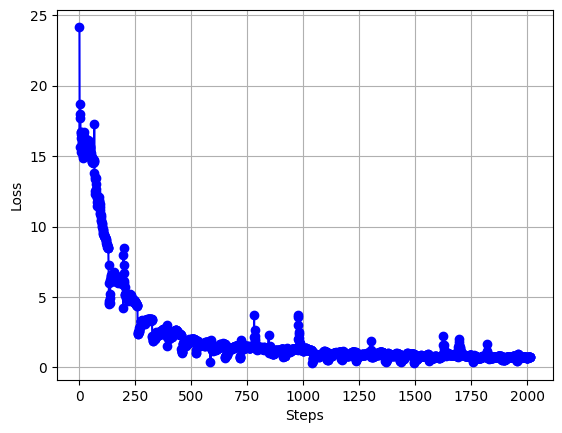

Epoch: 30
test loss
Validation Loss: 0.011056410072496364
Accuracy: 0.7776368249365713
Early Stopping


In [80]:
train(model, device, train_loader, test_loader, criterion, optimizer, epochs=100)

In [81]:
test(model, device, test_loader)

Validation Loss: 0.011056410072496364
Accuracy: 0.7776368249365713


0.7776368249365713

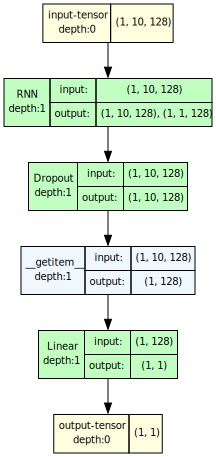

In [82]:
# from torchviz import make_dot
from torchview import draw_graph
import matplotlib.pyplot as plt
# Visualize the model
# x = torch.randn(1, 10, input_size)
# y = model(x)
# make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)])).render("rnn_torchviz", format="png")

# Display the generated graph
# img = plt.imread("rnn_torchviz.png")
# plt.imshow(img)
# plt.axis('off')

# Visualize the model
x = torch.randn(1, 10, input_dim).to(device)
y = model(x)
graph = draw_graph(model, input_size=(1, 10, input_dim), device=device)
graph.visual_graph.render("rnn_torchview", format="png")
graph.visual_graph

# Display the generated graph
# img = plt.imread("rnn_torchview.png")
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [83]:
from torchinfo import summary

summary(model, input_size=(1, 10, input_dim), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
AudioRNN                                 [1, 1]                    --
├─RNN: 1-1                               [1, 10, 128]              33,024
├─Dropout: 1-2                           [1, 10, 128]              --
├─Linear: 1-3                            [1, 1]                    129
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.33
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 0.13
Estimated Total Size (MB): 0.15

In [84]:
# save model
# name is time
import time
torch.save(model.state_dict(), f"./model_{time.time()}.pth")